In [1]:
#importing all the necessary modules
import csv
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import numpy as np

'''Opening the CSV file and reading its contents without using Pandas, we are using the DictReader csv module here for converting the read data into
key value pair'''
with open('Z:/UB_Sem1/prof_zia/final_project/bankloan.csv', 'r') as csvfile:
    csv_reader = csv.DictReader(csvfile)  #https://docs.python.org/3/library/csv.html

    # Connecting to the SQLite database
    conn = sqlite3.connect('Z:/UB_Sem1/prof_zia/final_project/final_db.db')
    cursor = conn.cursor()


# Creating tables for the normalized database
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS Customers (
        CustomerID INTEGER PRIMARY KEY,
        Age INTEGER,
        Experience INTEGER,
        Income INTEGER,
        ZIPCode INTEGER,
        Family INTEGER,
        CCAvg REAL,
        Education INTEGER,
        Mortgage INTEGER
        );
    ''')

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS LoanDetails (
        
        CustomerID INTEGER PRIMARY KEY,
        PersonalLoan INTEGER,
        FOREIGN KEY(CustomerID) REFERENCES Customers(CustomerID)
        );
    ''')

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS CustomerAccounts (
        
        CustomerID INTEGER PRIMARY KEY,
        SecuritiesAccount INTEGER,
        CDAccount INTEGER,
        FOREIGN KEY(CustomerID) REFERENCES Customers(CustomerID)
        );
    ''')

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS CustomerCredit (
        
        CustomerID INTEGER PRIMARY KEY,
        Online INTEGER,
        CreditCard INTEGER,
        FOREIGN KEY(CustomerID) REFERENCES Customers(CustomerID)
        );
    ''')

    for row in csv_reader:
        # Insert into Customers table
        cursor.execute('''
            INSERT OR IGNORE INTO Customers (CustomerID, Age, Experience, Income, ZIPCode, Family, CCAvg, Education, Mortgage)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (int(row['ID']), int(row['Age']), int(row['Experience']), int(row['Income']), int(row['ZIP.Code']),
              int(row['Family']), float(row['CCAvg']), int(row['Education']), int(row['Mortgage'])))

        # Insert into LoanDetails table
        cursor.execute('''
            INSERT OR IGNORE INTO LoanDetails (CustomerID, PersonalLoan)
            VALUES (?, ?)
        ''', (int(row['ID']), int(row['Personal.Loan'])))

        # Insert into CustomerAccounts table
        cursor.execute('''
            INSERT OR IGNORE INTO CustomerAccounts (CustomerID, SecuritiesAccount, CDAccount)
            VALUES (?, ?, ?)
        ''', (int(row['ID']), int(row['Securities.Account']), int(row['CD.Account'])))

        # Insert into CustomerCredit table
        cursor.execute('''
            INSERT OR IGNORE INTO CustomerCredit (CustomerID, Online, CreditCard)
            VALUES (?, ?, ?)
        ''', (int(row['ID']), int(row['Online']), int(row['CreditCard'])))

# Commit the changes and close connection
conn.commit()
#conn.close()


query = '''
    SELECT C.*, LD.PersonalLoan, CA.SecuritiesAccount, CA.CDAccount, CC.Online, CC.CreditCard
    FROM Customers AS C
    LEFT JOIN LoanDetails AS LD ON C.CustomerID = LD.CustomerID
    LEFT JOIN CustomerAccounts AS CA ON C.CustomerID = CA.CustomerID
    LEFT JOIN CustomerCredit AS CC ON C.CustomerID = CC.CustomerID;
'''

# Read SQL query results into Pandas DataFrame
combined_data = pd.read_sql_query(query, conn)

# Close connection
conn.close()

# Display the first few rows of the combined data
print(combined_data.head())

   CustomerID  Age  Experience  Income  ZIPCode  Family  CCAvg  Education  \
0           1   25           1      49    91107       4    1.6          1   
1           2   45          19      34    90089       3    1.5          1   
2           3   39          15      11    94720       1    1.0          1   
3           4   35           9     100    94112       1    2.7          2   
4           5   35           8      45    91330       4    1.0          2   

   Mortgage  PersonalLoan  SecuritiesAccount  CDAccount  Online  CreditCard  
0         0             0                  1          0       0           0  
1         0             0                  1          0       0           0  
2         0             0                  0          0       0           0  
3         0             0                  0          0       0           0  
4         0             0                  0          0       0           1  


Average Income: 73.7742
Loan Approval Rate: 9.6
Null Value Counts:
CustomerID           0
Age                  0
Experience           0
Income               0
ZIPCode              0
Family               0
CCAvg                0
Education            0
Mortgage             0
PersonalLoan         0
SecuritiesAccount    0
CDAccount            0
Online               0
CreditCard           0
dtype: int64


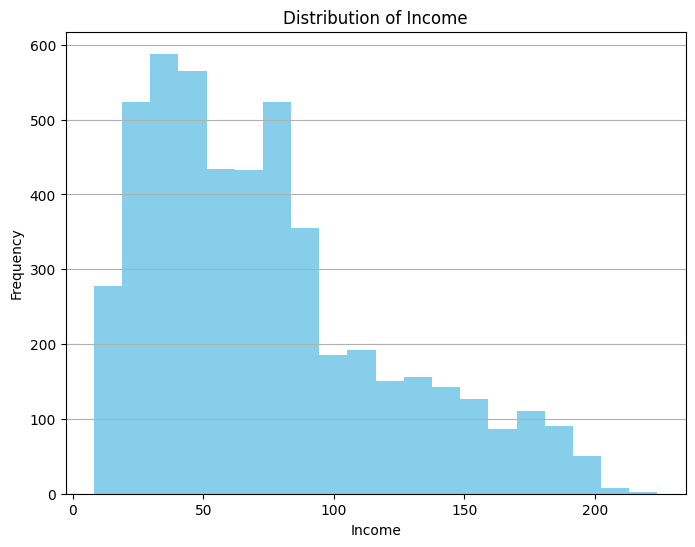

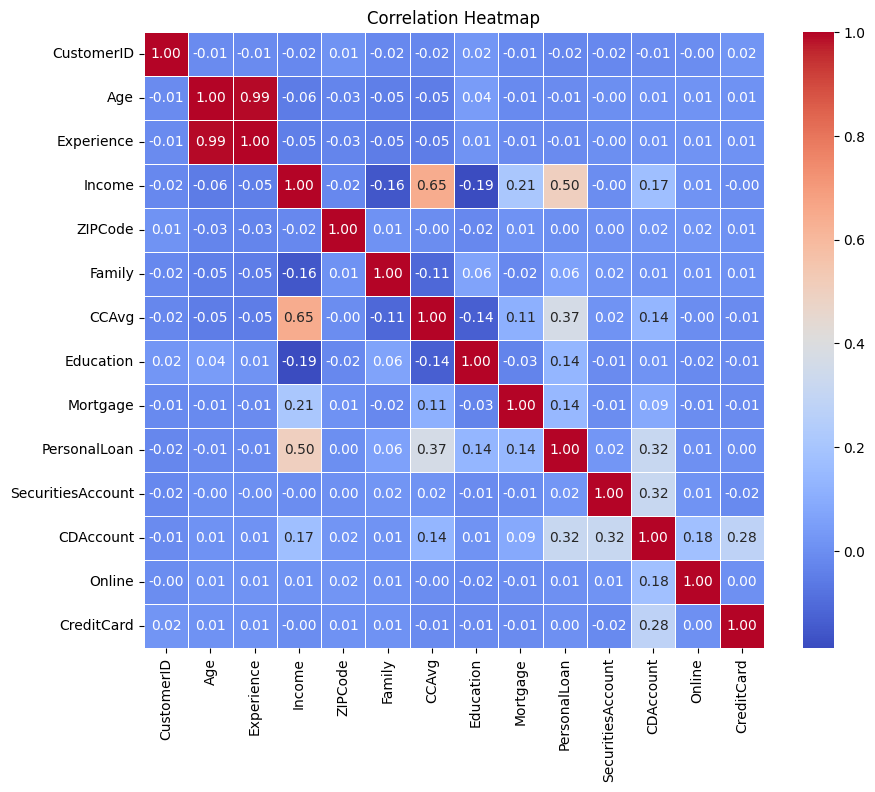

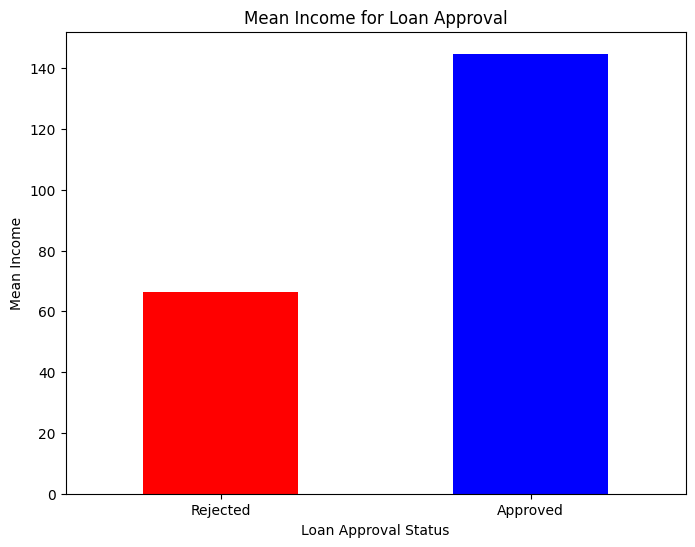

In [2]:
# Data Pre-Processing / EDA
# Calculate average income and loan approval rate
average_income = combined_data['Income'].mean()
loan_approval_rate = combined_data['PersonalLoan'].mean()
print("Average Income:", average_income)
print("Loan Approval Rate:", loan_approval_rate*100)

# Checking for null values
null_counts = combined_data.isnull().sum()
print("Null Value Counts:")
print(null_counts)

# Visualizing Distribution of Income
plt.figure(figsize=(8, 6))
plt.hist(combined_data['Income'], bins=20, color='skyblue')
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

# Analysing Correlation among the descriptors
correlation_matrix = combined_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5) # https://seaborn.pydata.org/generated/seaborn.heatmap.html
plt.title('Correlation Heatmap')
plt.show()

'''# Analysing the effect of Income on Loan approval status
plt.figure(figsize=(8, 6))
sns.boxplot(x='PersonalLoan', y='Income', data=combined_data) # https://seaborn.pydata.org/generated/seaborn.boxplot.html
plt.title('Effect of Income on Loan Approval')
plt.xlabel('Loan Approval Status')
plt.ylabel('Income')
plt.show()'''

# Analysing the effect of Income on Loan approval status
# Indicates that Loan has been approved for users having higher income
income_means = combined_data.groupby('PersonalLoan')['Income'].mean()
plt.figure(figsize=(8, 6))
income_means.plot(kind='bar', color=['red', 'blue'])
plt.title('Mean Income for Loan Approval')
plt.xlabel('Loan Approval Status')
plt.ylabel('Mean Income')
plt.xticks([0, 1], ['Rejected', 'Approved'], rotation=0) # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html
plt.show() 

Class Distribution:
PersonalLoan
0    4520
1     480
Name: count, dtype: int64

Percentage Distribution:
PersonalLoan
0    90.4
1     9.6
Name: count, dtype: float64


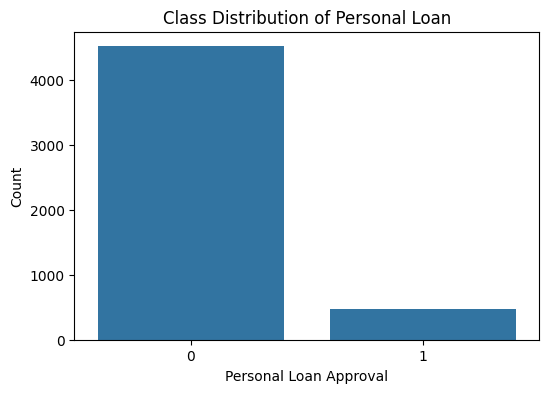

In [3]:
# Checking for class imbalance
class_distribution = combined_data['PersonalLoan'].value_counts()
percentage_distribution = class_distribution / len(combined_data) * 100
print("Class Distribution:")
print(class_distribution)
print("\nPercentage Distribution:")
print(percentage_distribution)

# Plot to show imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x='PersonalLoan', data=combined_data)
plt.title('Class Distribution of Personal Loan')
plt.xlabel('Personal Loan Approval')
plt.ylabel('Count')
plt.show()

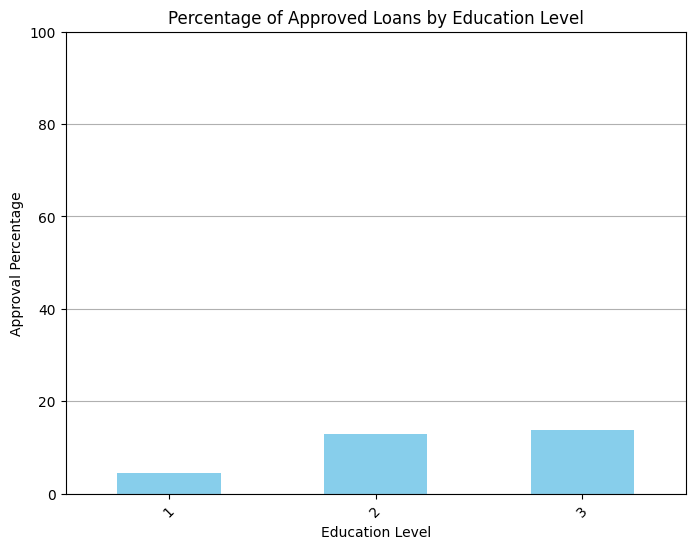

In [4]:
loan_approval_by_education = combined_data.groupby('Education')['PersonalLoan'].mean() * 100

plt.figure(figsize=(8, 6))
loan_approval_by_education.plot(kind='bar', color='skyblue')
plt.title('Percentage of Approved Loans by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Approval Percentage')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()

In [14]:
# Random Forest Model Training

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

median_experience = combined_data[combined_data['Experience'] >= 0]['Experience'].median()
combined_data.loc[combined_data['Experience'] < 0, 'Experience'] = median_experience


X = combined_data.drop(['PersonalLoan', 'CustomerID'], axis=1)
y = combined_data['PersonalLoan']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate using classification report

print(classification_report(y_test, predictions)) # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
# Evaluate model accuracy
accuracy = accuracy_score(y_test, predictions) # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
print("Accuracy:", accuracy)
print("\n")

conf_matrix = confusion_matrix(y_test, predictions)

# Create a DataFrame to display the confusion matrix
confusion_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print("Confusion Matrix:")
print(confusion_df)
print("\n")

"""[[TN, FP],
 [FN, TP]]

TN (True Negative): Actual class was negative, and the model correctly predicted it as negative.

FP (False Positive): Actual class was negative, but the model incorrectly predicted it as positive.

FN (False Negative): Actual class was positive, but the model incorrectly predicted it as negative.

TP (True Positive): Actual class was positive, and the model correctly predicted it as positive."""

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       895
           1       0.99      0.90      0.95       105

    accuracy                           0.99      1000
   macro avg       0.99      0.95      0.97      1000
weighted avg       0.99      0.99      0.99      1000

Accuracy: 0.989


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          894            1
Actual 1           10           95




'[[TN, FP],\n [FN, TP]]\n\nTN (True Negative): Actual class was negative, and the model correctly predicted it as negative.\n\nFP (False Positive): Actual class was negative, but the model incorrectly predicted it as positive.\n\nFN (False Negative): Actual class was positive, but the model incorrectly predicted it as negative.\n\nTP (True Positive): Actual class was positive, and the model correctly predicted it as positive.'

In [15]:
# Random Forest with SMOTE

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

median_experience = combined_data[combined_data['Experience'] >= 0]['Experience'].median()
combined_data.loc[combined_data['Experience'] < 0, 'Experience'] = median_experience



X = combined_data.drop(['PersonalLoan', 'CustomerID'], axis=1)
y = combined_data['PersonalLoan']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#We are doing smote resampling here to handle the issue of imbalance in our data and then check the updated accuracy of our model
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)

# Make predictions
predictions = model.predict(X_test)

# Evaluate using classification report

print(classification_report(y_test, predictions)) # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
# Evaluate model accuracy
accuracy = accuracy_score(y_test, predictions) # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
print("Accuracy:", accuracy)
print("\n")

conf_matrix = confusion_matrix(y_test, predictions)

# Create a DataFrame to display the confusion matrix
confusion_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print("Confusion Matrix:")
print(confusion_df)
print("\n")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       895
           1       0.89      0.94      0.92       105

    accuracy                           0.98      1000
   macro avg       0.94      0.96      0.95      1000
weighted avg       0.98      0.98      0.98      1000

Accuracy: 0.982


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          883           12
Actual 1            6           99




In [16]:
# Logistic Regression Model

from sklearn.metrics import classification_report
# Train Logistic Regression model for Loan prediction
from sklearn.linear_model import LogisticRegression

median_experience = combined_data[combined_data['Experience'] >= 0]['Experience'].median()
combined_data.loc[combined_data['Experience'] < 0, 'Experience'] = median_experience


X = combined_data.drop(['PersonalLoan', 'CustomerID'], axis=1)  # Features
y = combined_data['PersonalLoan']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate model accuracy
accuracy = accuracy_score(y_test, predictions) # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
print("Accuracy:", accuracy)
print("\n")

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
# Create a DataFrame to display the confusion matrix
confusion_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print("Confusion Matrix:")
print(confusion_df)
print("\n")

print(classification_report(y_test, predictions))

Accuracy: 0.952


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          884           11
Actual 1           37           68


              precision    recall  f1-score   support

           0       0.96      0.99      0.97       895
           1       0.86      0.65      0.74       105

    accuracy                           0.95      1000
   macro avg       0.91      0.82      0.86      1000
weighted avg       0.95      0.95      0.95      1000



In [17]:
# Logistic Regression with SMOTE

median_experience = combined_data[combined_data['Experience'] >= 0]['Experience'].median()
combined_data.loc[combined_data['Experience'] < 0, 'Experience'] = median_experience

X = combined_data.drop(['PersonalLoan', 'CustomerID'], axis=1)  # Features
y = combined_data['PersonalLoan']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



#We are doing smote resampling here to handle the issue of imbalance in our data and then check the updated accuracy of our model
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)


# Make predictions
predictions = model.predict(X_test)

# Evaluate model accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("\n")
# Create a DataFrame to display the confusion matrix
confusion_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print("Confusion Matrix:")
print(confusion_df)
print("\n")
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

Accuracy: 0.881


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          789          106
Actual 1           13           92


              precision    recall  f1-score   support

           0       0.98      0.88      0.93       895
           1       0.46      0.88      0.61       105

    accuracy                           0.88      1000
   macro avg       0.72      0.88      0.77      1000
weighted avg       0.93      0.88      0.90      1000

